In [ ]:
pip install gdown

In [ ]:
pip install python-louvain

In [ ]:
import pandas as pd
import gdown
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community.community_louvain as community_louvain

In [ ]:
# File ID from Google Drive
file_id = '1v6joXmQnknrFouwP0-kJvIgl_A8UZl7E'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Output file names
downloaded_file = 'waze_data'
csv_output = 'cleaned_waze_app_dataset.csv'

# Download the file using gdown
gdown.download(download_url, downloaded_file, quiet=False)

try:
    # Try to load the file as an Excel file
    waze_data_df = pd.read_excel(downloaded_file, engine='openpyxl')
except Exception as e:
    print("Error reading as Excel, trying as CSV:", e)
    # Try to read as CSV
    waze_data_df = pd.read_csv(downloaded_file)

waze_data_df.head()

Downloading...
From: https://drive.google.com/uc?id=1v6joXmQnknrFouwP0-kJvIgl_A8UZl7E
To: /content/waze_data
100%|██████████| 1.20M/1.20M [00:00<00:00, 74.2MB/s]


Error reading as Excel, trying as CSV: File is not a zip file


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [ ]:
# Clean the dataset by dropping rows with missing 'label'
dataset_cleaned = waze_data_df.dropna(subset=['label']).copy()

# Remove the 'sessions' column (stay with the 'total_sessions')
dataset_cleaned = dataset_cleaned.drop(columns=['sessions'])

# Drop rows with "n_days_after_onboarding" under 2 years (730 days)
dataset_cleaned = dataset_cleaned[dataset_cleaned['n_days_after_onboarding'] > 730]

# Drop rows with "drives" (last month) equals to 0 or under 50
dataset_cleaned = dataset_cleaned[dataset_cleaned['drives'] != 0]
dataset_cleaned = dataset_cleaned[dataset_cleaned['drives'] > 20]

# Drop rows with "total_sessions" (total) under 50
dataset_cleaned = dataset_cleaned[dataset_cleaned['total_sessions'] > 50]

# Drop rows with "driven_km_drives" (total) under 200
dataset_cleaned = dataset_cleaned[dataset_cleaned['driven_km_drives'] > 200]

# Drop rows with "duration_minutes_drives" (last month) under 2 hours (120 minutes)
dataset_cleaned = dataset_cleaned[dataset_cleaned['duration_minutes_drives'] > 120]

# Drop rows with "activity_days" (last month) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['activity_days'] != 0]

# Drop rows with "driving_days" (last month) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['driving_days'] != 0]

# Get the number of records
num_records = len(dataset_cleaned)
print(f"Number of records after cleaning: {num_records}")

# Export to CSV
dataset_cleaned.to_csv(csv_output, index=False)
print(f"The cleaned dataset has been exported to {csv_output}")

# Display the first few rows of the cleaned dataset
dataset_cleaned.head()

Number of records after cleaning: 7576
The cleaned dataset has been exported to cleaned_waze_app_dataset.csv


,ID,label,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
4,4,retained,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone


In [ ]:
# Split the dataset into iPhone and Android users
iphone_users = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']
android_users = dataset_cleaned[dataset_cleaned['device'] == 'Android']
pd.DataFrame(iphone_users).head(5)
print("Android users -",len(android_users))
print("Iphone users -" , len(iphone_users))

Android users - 2707
Iphone users - 4869


**threshold of 30 - iPhone users**

---


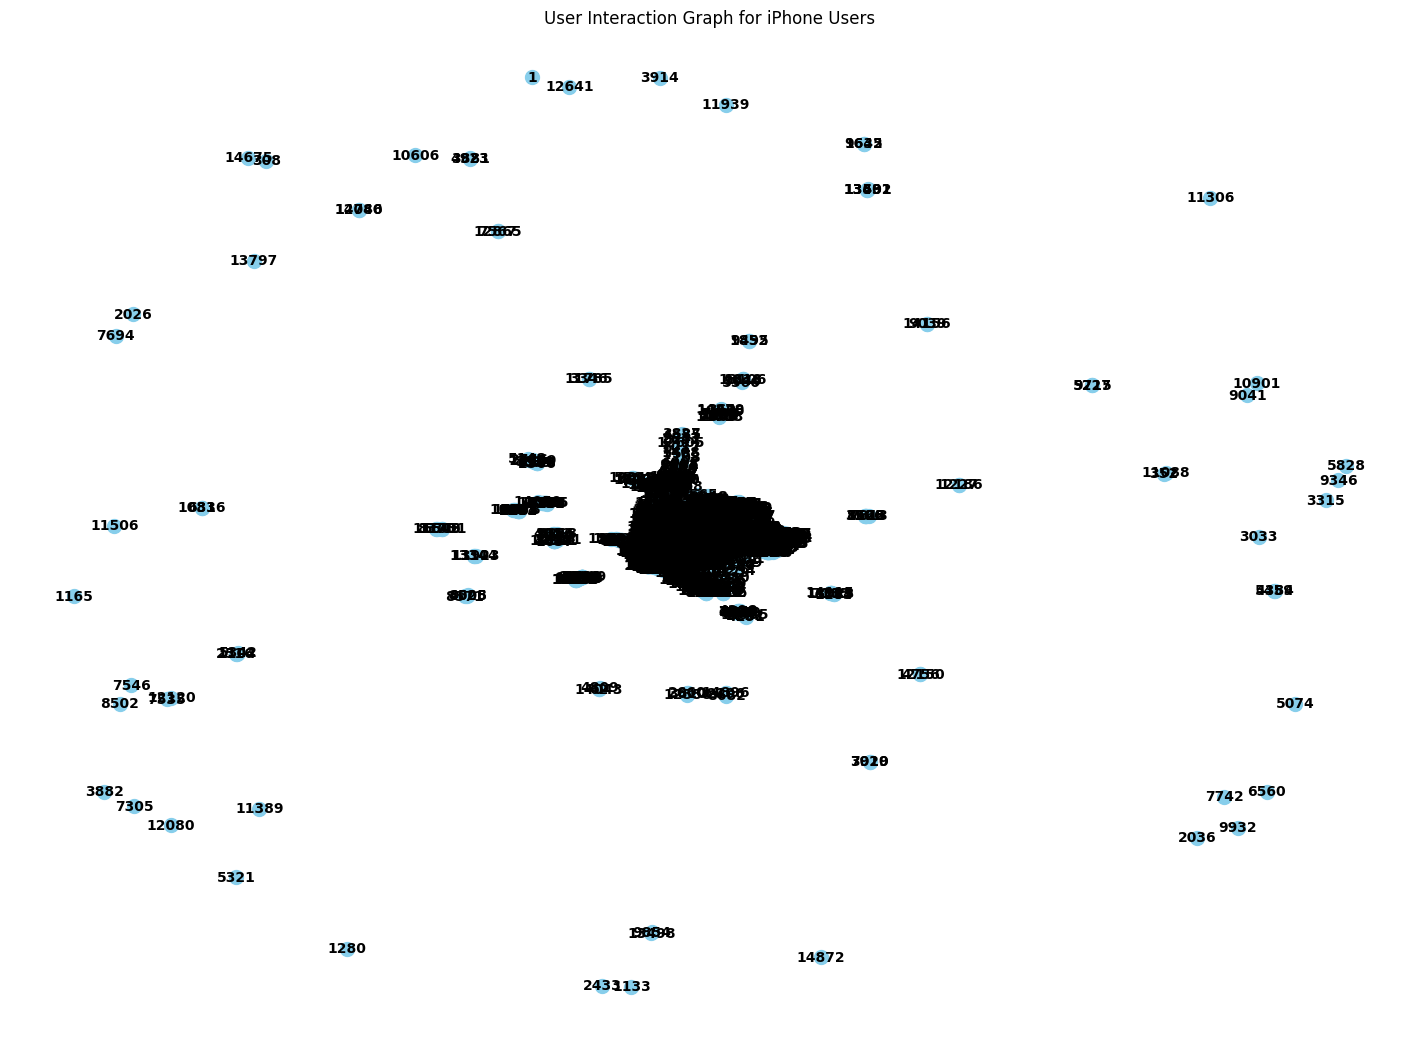

In [ ]:
# Split the sample into iPhone users
iphone_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graph for iPhone users in the sample
threshold_km = 30
G_iphone_sample = create_graph(iphone_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for iPhone users
draw_graph(G_iphone_sample, 'User Interaction Graph for iPhone Users', 'skyblue')



**threshold of 60 - iPhone users**

---

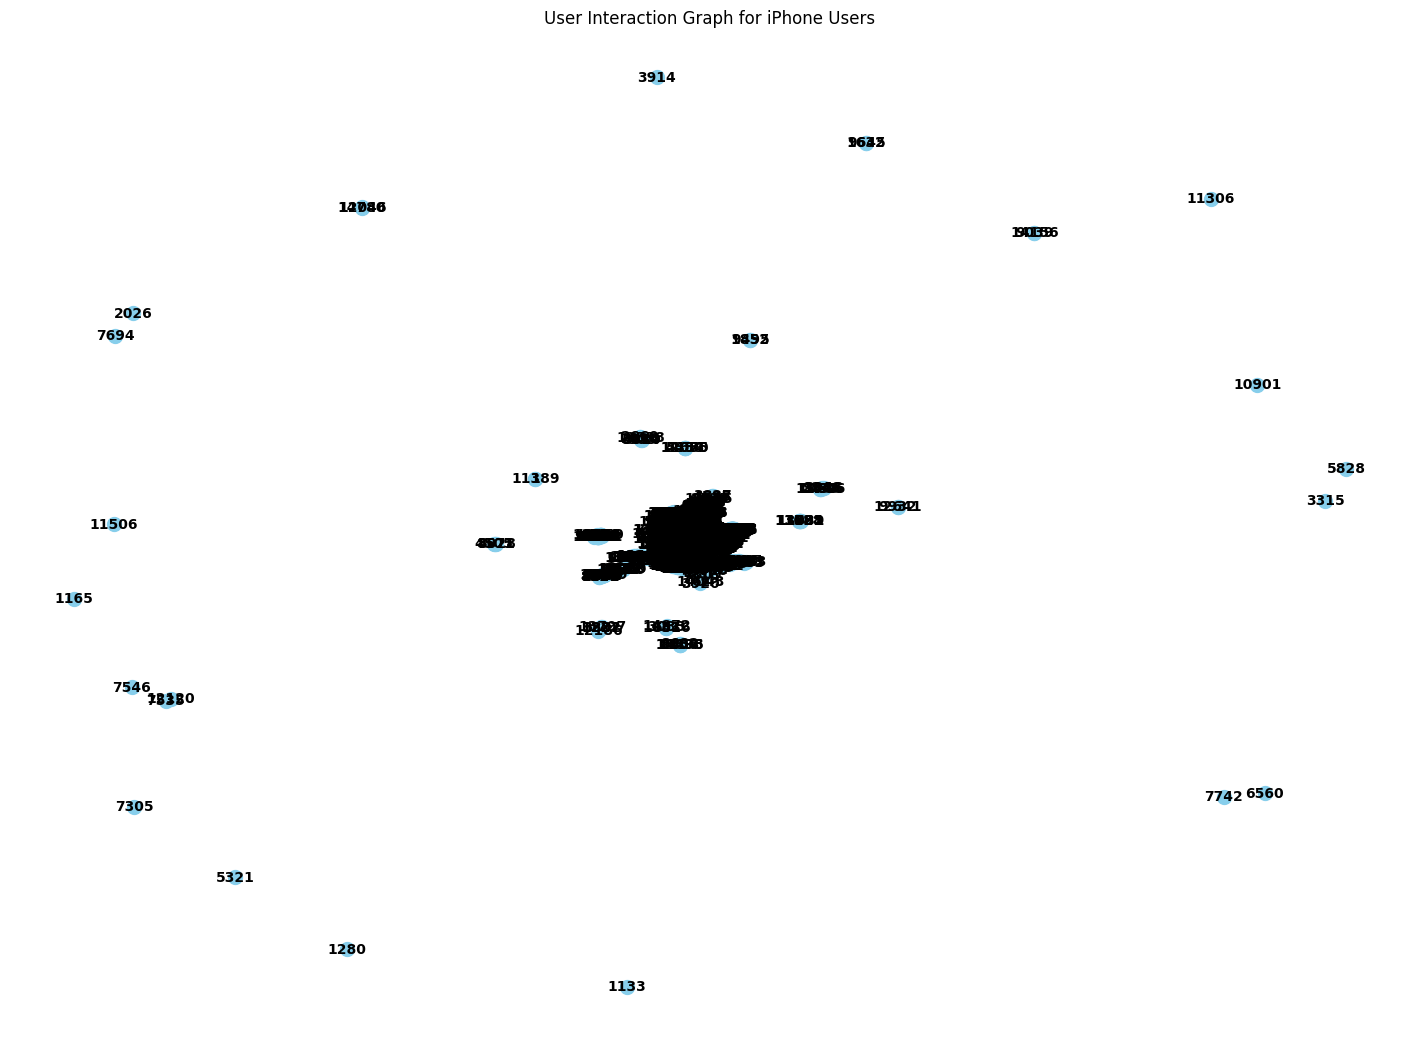

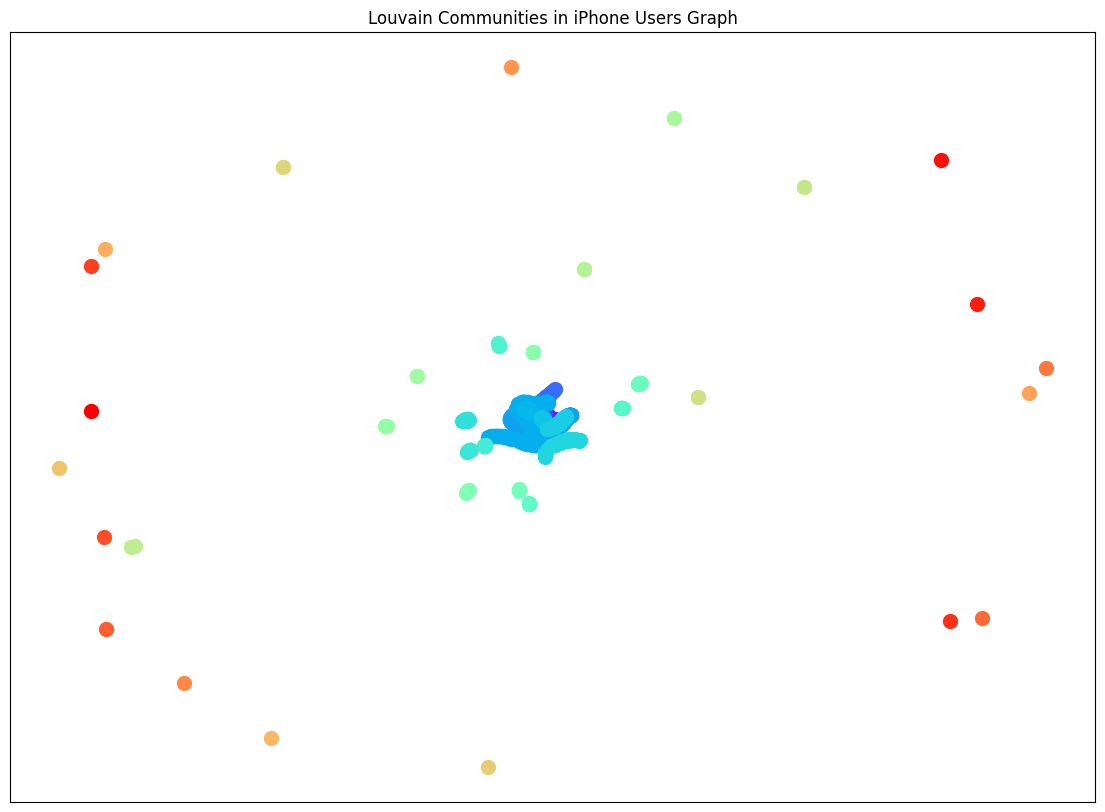

[[38,
  69,
  103,
  189,
  211,
  263,
  276,
  350,
  422,
  444,
  466,
  505,
  515,
  518,
  526,
  551,
  554,
  564,
  584,
  619,
  644,
  699,
  735,
  764,
  880,
  887,
  916,
  927,
  932,
  954,
  998,
  1021,
  1022,
  1025,
  1043,
  1044,
  1051,
  1059,
  1079,
  1086,
  1098,
  1109,
  1150,
  1171,
  1184,
  1202,
  1228,
  1287,
  1311,
  1315,
  1329,
  1338,
  1377,
  1386,
  1400,
  1410,
  1414,
  1435,
  1523,
  1530,
  1538,
  1578,
  1597,
  1602,
  1634,
  1648,
  1657,
  1734,
  1745,
  1756,
  1768,
  1830,
  1841,
  1864,
  1878,
  1926,
  1954,
  1992,
  2005,
  2068,
  2136,
  2152,
  2183,
  2195,
  2298,
  2315,
  2373,
  2380,
  2390,
  2404,
  2412,
  2417,
  2426,
  2430,
  2449,
  2458,
  2542,
  2564,
  2611,
  2670,
  2676,
  2690,
  2726,
  2782,
  2794,
  2878,
  2885,
  2927,
  2936,
  2999,
  3069,
  3088,
  3104,
  3113,
  3131,
  3137,
  3143,
  3154,
  3222,
  3247,
  3257,
  3299,
  3336,
  3340,
  3353,
  3371,
  3372,
  3390,
  3397,
 

In [ ]:
# iPhone users
iphone_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graph for iPhone users in the sample
threshold_km = 60
G_iphone_sample = create_graph(iphone_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for iPhone users
draw_graph(G_iphone_sample, 'User Interaction Graph for iPhone Users', 'skyblue')


# Function to detect communities using the Louvain algorithm
def detect_louvain_communities(G):
    # Using the Louvain method to find communities
    partition = community_louvain.best_partition(G)
    # Group nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    sorted_communities = sorted(communities.values(), key=len, reverse=True)
    return sorted_communities

# Detect communities in the iPhone users graph using Louvain
iphone_louvain_communities = detect_louvain_communities(G_iphone_sample)

# Function to draw communities using Louvain
def draw_louvain_communities(G, communities, title):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color], label=community, node_size=100)  # Increase node size
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.show()

# Draw communities for iPhone users using Louvain
draw_louvain_communities(G_iphone_sample, iphone_louvain_communities, 'Louvain Communities in iPhone Users Graph')

iphone_louvain_communities


**threshold of 70 - iPhone users**

---

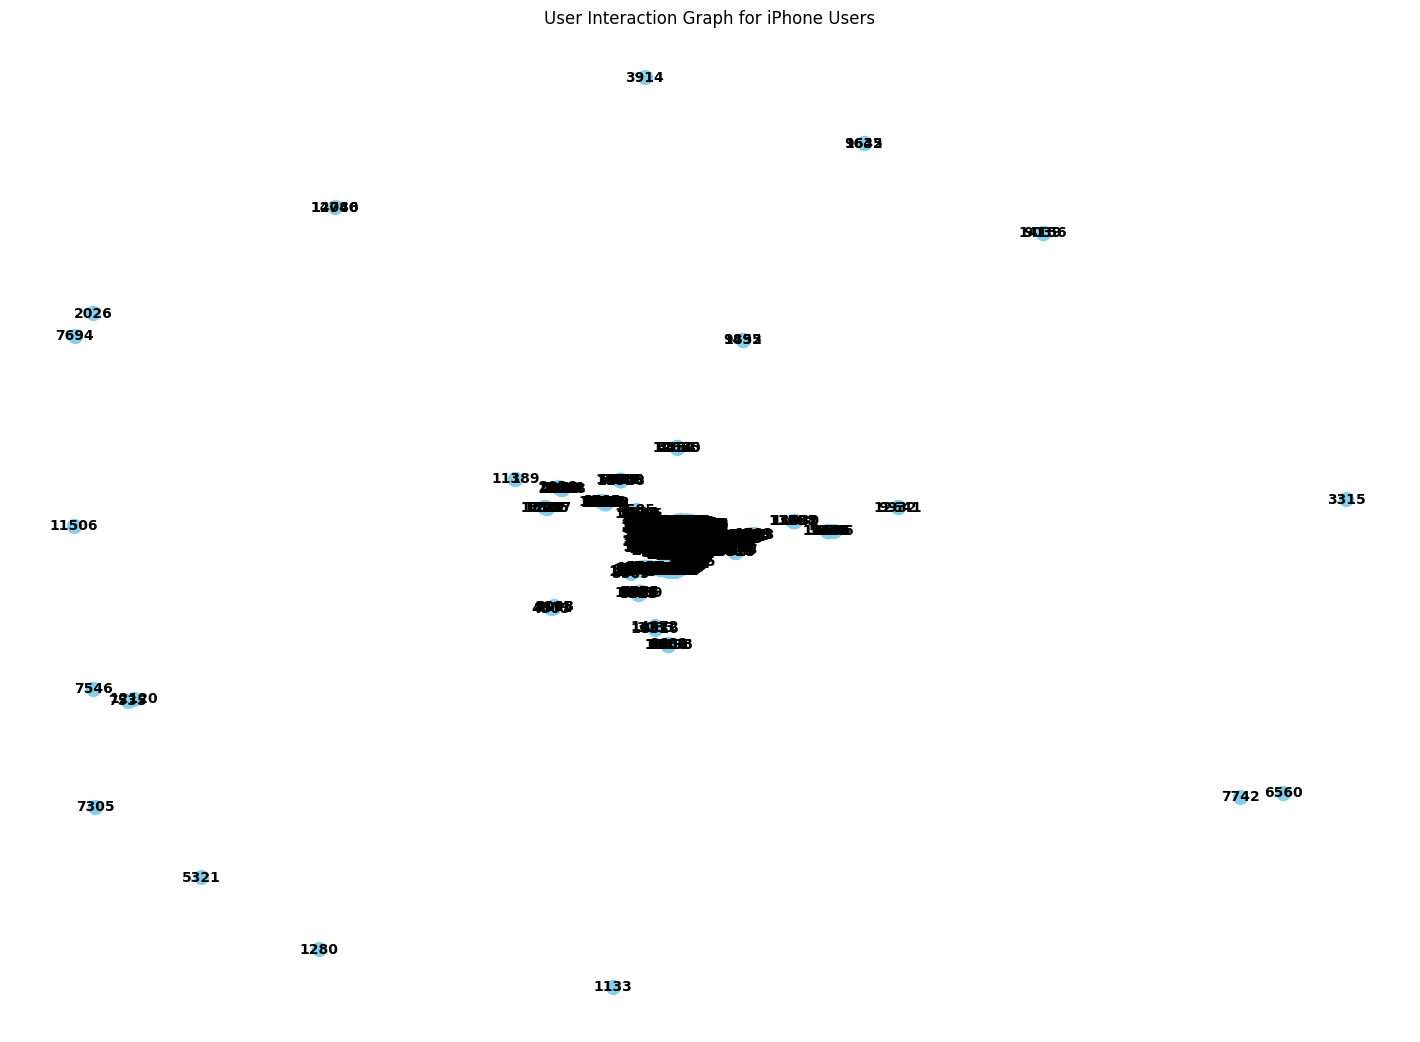

In [ ]:
# iPhone users - threshold_km of 70
iphone_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graph for iPhone users in the sample
threshold_km = 70
G_iphone_sample = create_graph(iphone_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for iPhone users
draw_graph(G_iphone_sample, 'User Interaction Graph for iPhone Users', 'skyblue')



**threshold of 100 - iPhone users**

---

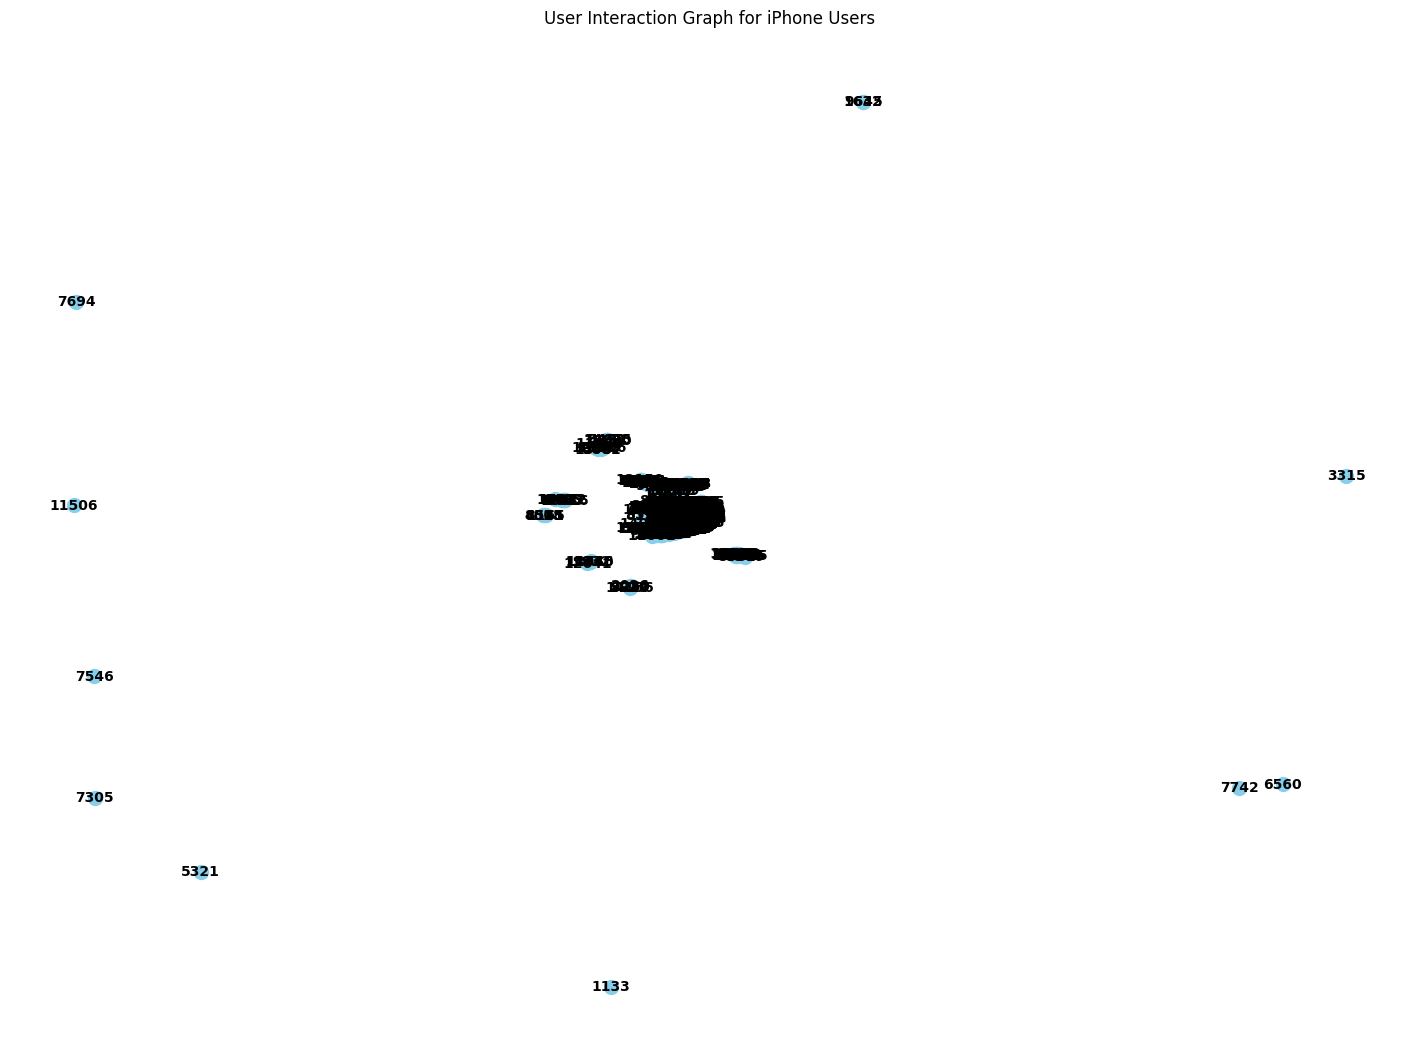

In [ ]:
# iPhone users - threshold_km of 70
iphone_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graph for iPhone users in the sample
threshold_km = 100
G_iphone_sample = create_graph(iphone_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for iPhone users
draw_graph(G_iphone_sample, 'User Interaction Graph for iPhone Users', 'skyblue')



**threshold of 60 - Android users**

---


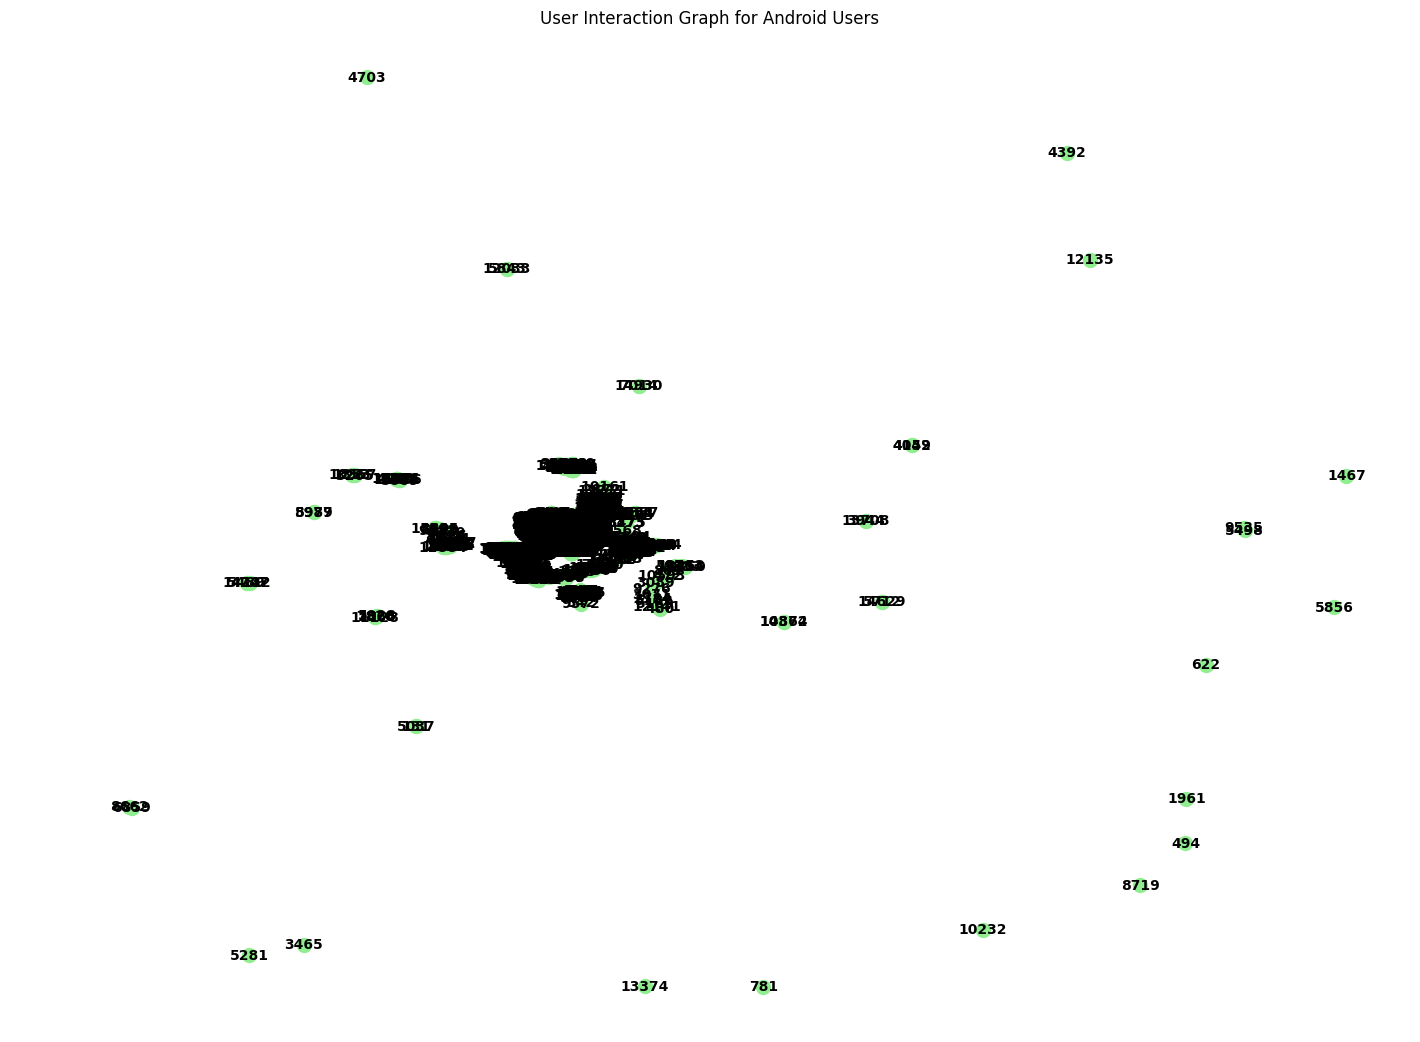

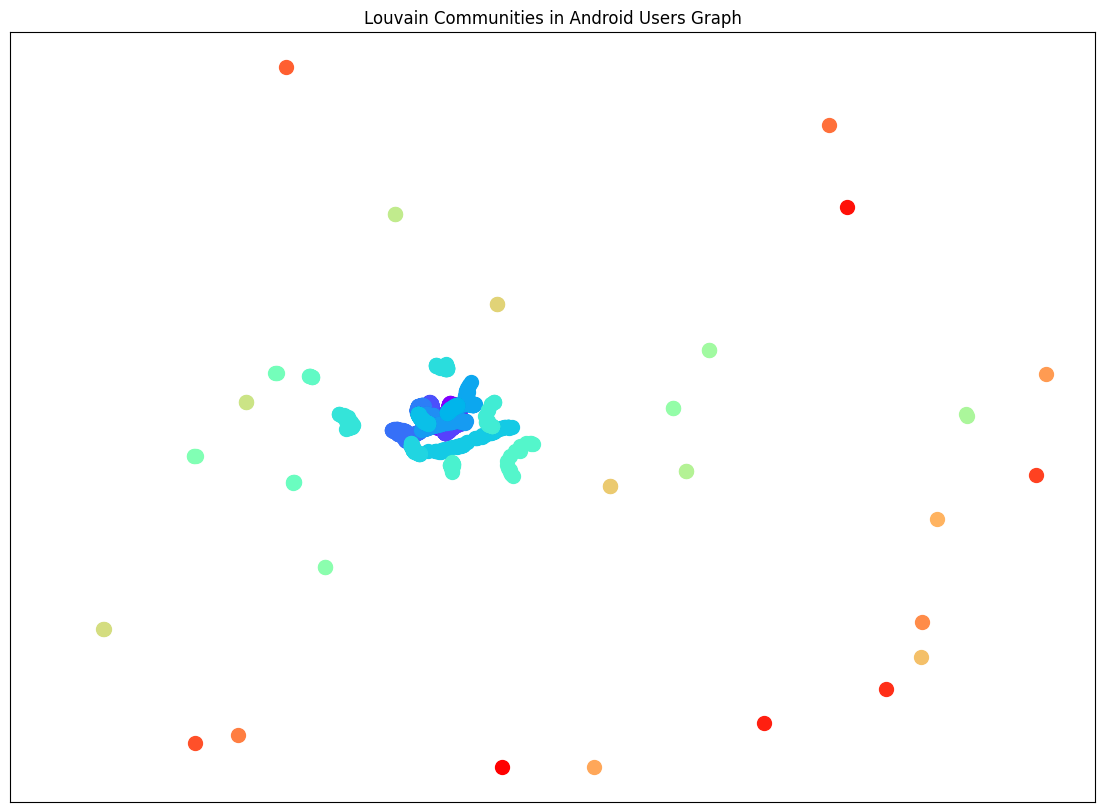

[[42,
  43,
  79,
  117,
  124,
  137,
  254,
  337,
  424,
  441,
  579,
  594,
  646,
  682,
  691,
  700,
  775,
  798,
  863,
  938,
  940,
  979,
  1014,
  1087,
  1129,
  1336,
  1396,
  1466,
  1562,
  1619,
  1696,
  1764,
  1770,
  1987,
  2084,
  2423,
  2450,
  2501,
  2506,
  2509,
  2691,
  2730,
  2815,
  2854,
  3127,
  3133,
  3152,
  3268,
  3273,
  3362,
  3540,
  3594,
  3648,
  3665,
  3706,
  3843,
  3854,
  3906,
  3919,
  3927,
  3949,
  4091,
  4207,
  4213,
  4268,
  4292,
  4371,
  4425,
  4435,
  4549,
  4624,
  4628,
  4795,
  4807,
  4870,
  4940,
  4957,
  4986,
  5114,
  5166,
  5211,
  5212,
  5255,
  5297,
  5325,
  5348,
  5410,
  5422,
  5439,
  5446,
  5470,
  5512,
  5520,
  5538,
  5686,
  5832,
  5882,
  5923,
  5927,
  6147,
  6343,
  6411,
  6481,
  6502,
  6527,
  6627,
  6772,
  6829,
  6845,
  6865,
  6913,
  6925,
  7041,
  7043,
  7140,
  7154,
  7164,
  7308,
  7445,
  7608,
  7741,
  7790,
  7809,
  7846,
  7916,
  7971,
  8004,
  8020,
 

In [ ]:
# Android users- threshold_km of 60
android_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'Android']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graphs for Android users
threshold_km = 60
G_android_sample = create_graph(android_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for Android users
draw_graph(G_android_sample, 'User Interaction Graph for Android Users', 'lightgreen')

# Function to detect communities using the Louvain algorithm
def detect_louvain_communities(G):
    # Using the Louvain method to find communities
    partition = community_louvain.best_partition(G)
    # Group nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    sorted_communities = sorted(communities.values(), key=len, reverse=True)
    return sorted_communities

# Detect communities in the Android users graph using Louvain
android_louvain_communities = detect_louvain_communities(G_android_sample)

# Function to draw communities using Louvain
def draw_louvain_communities(G, communities, title):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color], label=community, node_size=100)  # Increase node size
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.show()

# Draw communities for Android users using Louvain
draw_louvain_communities(G_android_sample, android_louvain_communities, 'Louvain Communities in Android Users Graph')

android_louvain_communities

**threshold of 30 - Android users**

---

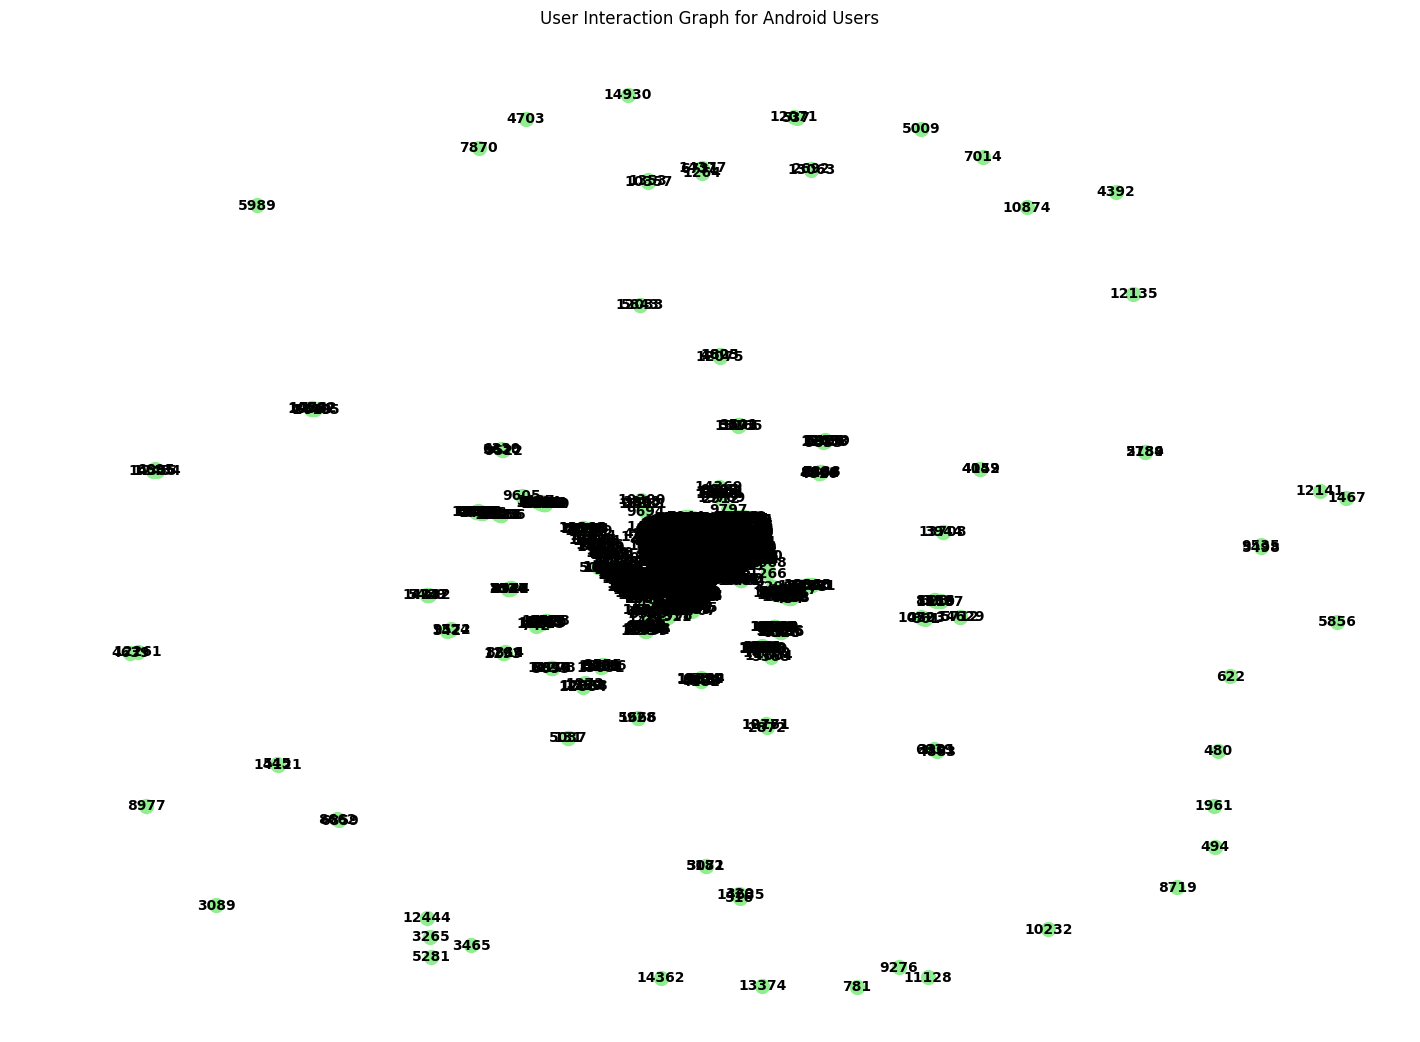

In [ ]:
# Android users- threshold_km of 60
android_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'Android']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graphs for Android users
threshold_km = 30
G_android_sample = create_graph(android_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for Android users
draw_graph(G_android_sample, 'User Interaction Graph for Android Users', 'lightgreen')

# Function to detect communities using the Louvain algorithm
def detect_louvain_communities(G):
    # Using the Louvain method to find communities
    partition = community_louvain.best_partition(G)
    # Group nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    sorted_communities = sorted(communities.values(), key=len, reverse=True)
    return sorted_communities


**threshold of 70 - Android users**

---

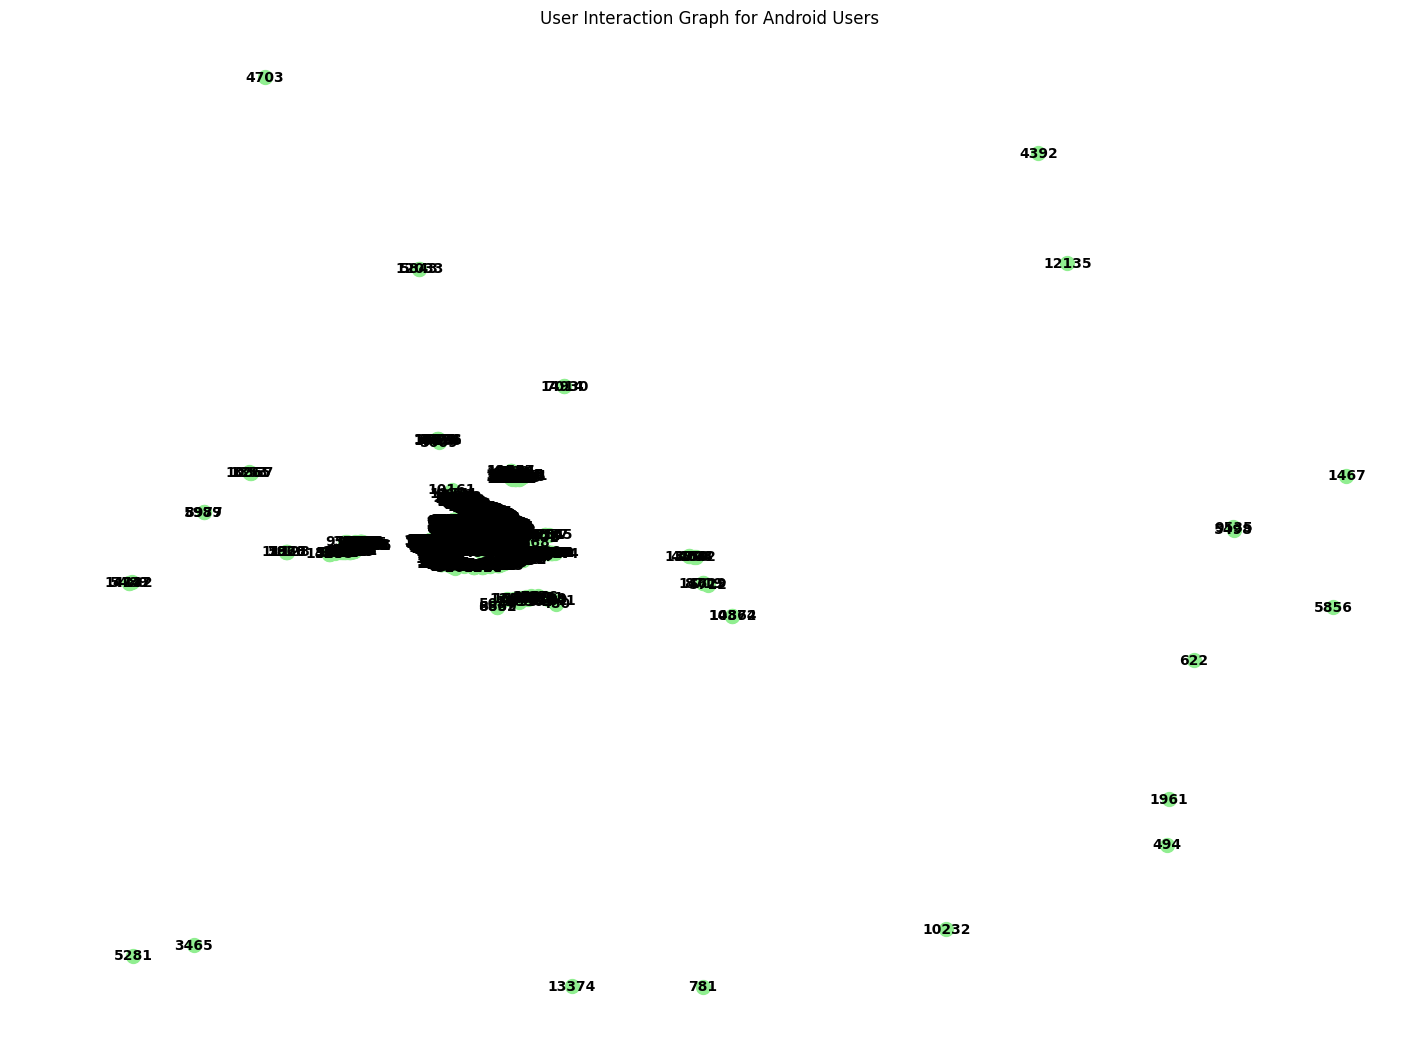

In [ ]:
# Android users- threshold_km of 60
android_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'Android']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graphs for Android users
threshold_km = 70
G_android_sample = create_graph(android_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for Android users
draw_graph(G_android_sample, 'User Interaction Graph for Android Users', 'lightgreen')

# Function to detect communities using the Louvain algorithm
def detect_louvain_communities(G):
    # Using the Louvain method to find communities
    partition = community_louvain.best_partition(G)
    # Group nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    sorted_communities = sorted(communities.values(), key=len, reverse=True)
    return sorted_communities

**threshold of 100 - Android users**

---

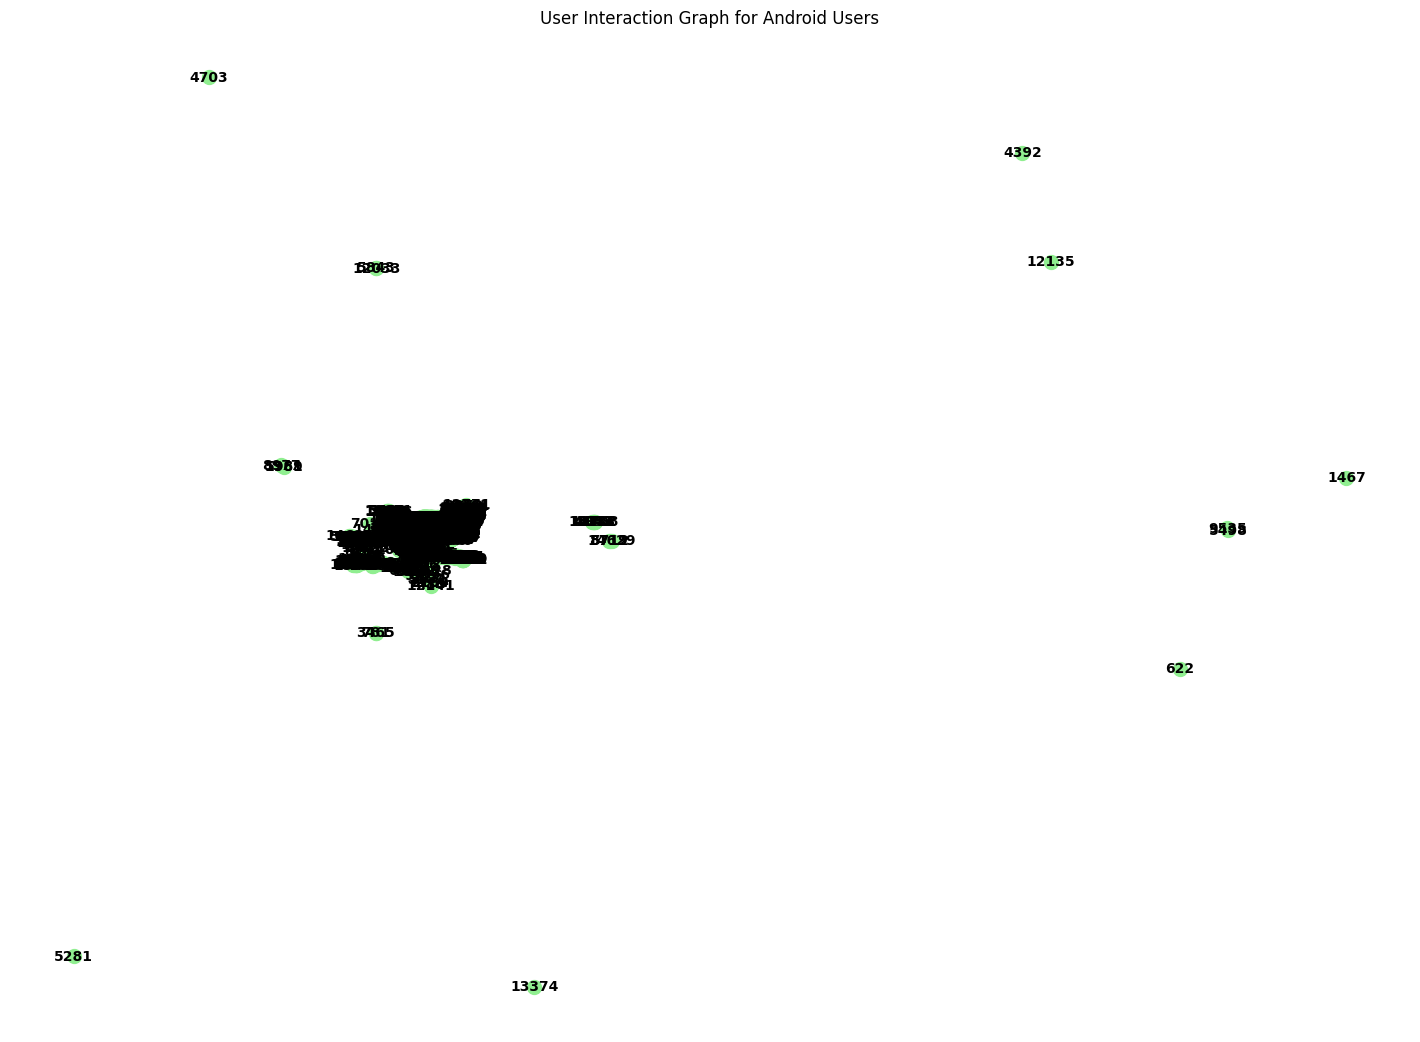

In [ ]:
# Android users- threshold_km of 60
android_users_sample = dataset_cleaned[dataset_cleaned['device'] == 'Android']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graphs for Android users
threshold_km = 100
G_android_sample = create_graph(android_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for Android users
draw_graph(G_android_sample, 'User Interaction Graph for Android Users', 'lightgreen')

# Function to detect communities using the Louvain algorithm
def detect_louvain_communities(G):
    # Using the Louvain method to find communities
    partition = community_louvain.best_partition(G)
    # Group nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    sorted_communities = sorted(communities.values(), key=len, reverse=True)
    return sorted_communities